# Mean-variance optimization

In this cookbook recipe, we work on several examples demonstrating PyPortfolioOpt's mean-variance capabilities. I will discuss what I think should be your "default" options, based on my experience in optimising portfolios.

To start, you need a list of tickers. Some people just provide the whole universe of stocks, but I don't think this is a good idea - portfolio optimization is quite different from asset selection. I would suggest anywhere from 10-50 stocks as a starting point.

Some of the things we cover:

- Downloading data and getting it into PyPortfolioOpt
- Calculating and visualising the covariance matrix
- Optimising a long/short portfolio to minimise total variance
- Optimising a portfolio to maximise the Sharpe ratio, subject to sector constraints
- Optimising a portfolio to maximise return for a given risk, subject to sector constraints, with an L2 regularisation objective
- Optimising a market-neutral portfolio to minimise risk for a given level of return
- Optimising along the mean-semivariance frontier
- Optimising along the mean-CVaR frontier
- Plotting the efficient frontier:
    - Simple (using CLA)
    - Constrained
    - Complex plots

Please consult the [docs](https://pyportfolioopt.readthedocs.io/) for more info.

## Downloading data

To download data, we will use `yfinance`, an excellent library that provides free price data from Yahoo Finance, no API key needed.

In [80]:
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [81]:
tickers = ["MSFT", "AMZN", "KO", "MA", "COST", 
           "LUV", "XOM", "PFE", "JPM", "UNH", 
           "ACN", "DIS", "GILD", "F", "TSLA","VTI"] 

In [82]:
ohlc = yf.download(tickers, period="max")

[*********************100%***********************]  16 of 16 completed


In [86]:
prices = ohlc["Adj Close"].dropna(how="all")
prices.head()

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,VTI,XOM
Date,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,0.058398,NaN,NaN,NaN,0.051133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.102984
1962-01-03,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.049994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.104513
1962-01-04,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.050374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.104768
1962-01-05,NaN,NaN,NaN,0.059378,NaN,NaN,NaN,0.049234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.102474
1962-01-08,NaN,NaN,NaN,0.059182,NaN,NaN,NaN,0.048728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.102219


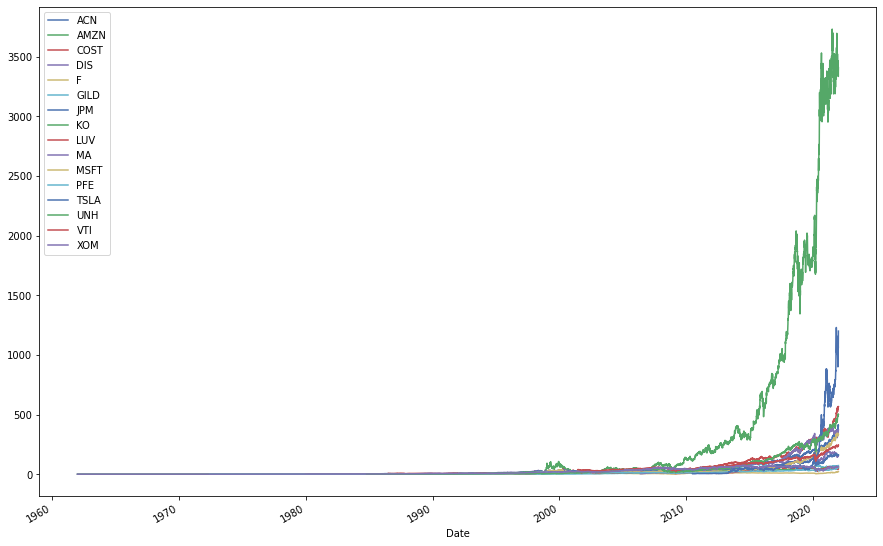

In [85]:
prices.plot(figsize=(15,10));

## Calculating the covariance matrix

In [6]:
import pypfopt
pypfopt.__version__

'1.5.1'

In [7]:
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.exp_cov(prices, frequency=252)
sample_cov

,ACN,AMZN,COST,DIS,F,GILD,JPM,KO,LUV,MA,MSFT,PFE,TSLA,UNH,VTI,XOM
ACN,0.053318,0.013264,0.017934,0.015710,0.024193,0.008200,0.018248,0.017179,0.010015,0.035679,0.025966,0.006878,0.023035,0.019307,0.020561,0.019401
AMZN,0.013264,0.061435,0.015623,0.016119,0.010856,0.002754,0.004193,0.003834,0.013733,0.023542,0.029601,-0.014148,0.033163,0.011785,0.020233,0.007897
COST,0.017934,0.015623,0.046161,0.000680,0.025930,0.005141,0.002516,0.014094,-0.007034,0.012642,0.027417,0.005179,0.029602,0.014532,0.015325,0.003967
DIS,0.015710,0.016119,0.000680,0.067899,0.028685,0.002825,0.026300,0.012853,0.052915,0.043508,0.014426,-0.011443,0.031887,0.014663,0.020562,0.030345
F,0.024193,0.010856,0.025930,0.028685,0.173525,0.005465,0.041572,0.016520,0.047120,0.023961,0.021341,-0.009089,0.056573,0.015334,0.027198,0.053047
GILD,0.008200,0.002754,0.005141,0.002825,0.005465,0.030523,0.006167,0.006887,0.000625,0.002307,0.001290,0.013106,0.002018,0.007578,0.005262,0.005714
JPM,0.018248,0.004193,0.002516,0.026300,0.041572,0.006167,0.049353,0.013112,0.041721,0.029662,0.006453,-0.003181,0.014252,0.016003,0.017901,0.041563
KO,0.017179,0.003834,0.014094,0.012853,0.016520,0.006887,0.013112,0.026009,0.010812,0.018751,0.013642,0.001526,0.000045,0.014395,0.011079,0.014910
LUV,0.010015,0.013733,-0.007034,0.052915,0.047120,0.000625,0.041721,0.010812,0.123322,0.040564,0.006426,-0.015173,0.040073,0.003963,0.024389,0.046666
MA,0.035679,0.023542,0.012642,0.043508,0.023961,0.002307,0.029662,0.018751,0.040564,0.099145,0.022453,-0.005619,0.029936,0.024225,0.028088,0.036590


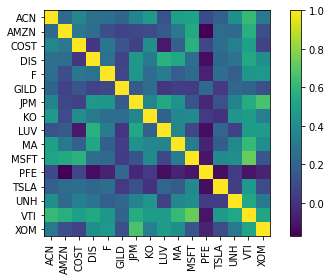

In [8]:
plotting.plot_covariance(sample_cov, plot_correlation=True);

For reasons discussed in the docs, the sample covariance matrix should not be your default choice. I think a better option is Ledoit-Wolf shrinkage, which reduces the extreme values in the covariance matrix. In the image below, we can see that there are fewer bright spots outside the diagonal:

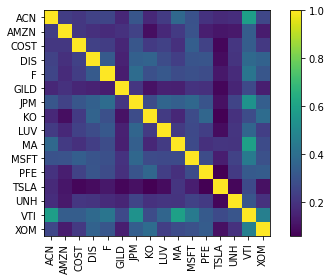

In [9]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

## Return estimation

As discussed in the docs, it is often a bad idea to provide returns using a simple estimate like the mean of past returns. Unless you have a proprietary method for estimating returns, research suggests that you may be better off not providing expected returns – you can then just find the `min_volatility()` portfolio or use `HRP`. 

However, in this example we will use the CAPM returns, which aims to be slightly more stable than the default mean historical return. Please see the notebook `1-RiskReturnModels.ipynb` for more information.

In [10]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(prices)
mu

ACN     0.207715
AMZN    0.355650
COST    0.195494
DIS     0.225671
F       0.225002
GILD    0.256744
JPM     0.254610
KO      0.149948
LUV     0.228559
MA      0.262037
MSFT    0.240321
PFE     0.180255
TSLA    0.275101
UNH     0.222715
VTI     0.198547
XOM     0.143299
Name: mkt, dtype: float64

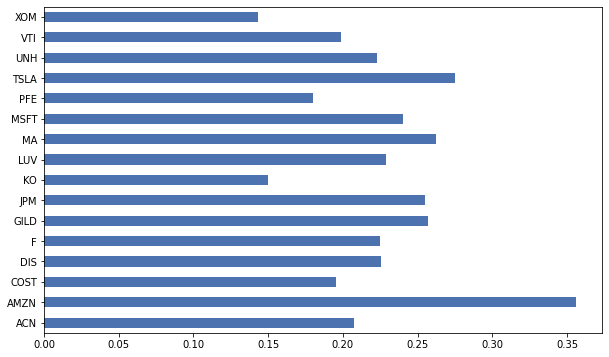

In [11]:
mu.plot.barh(figsize=(10,6));

## Long/short min variance

In this section, we construct a long/short portfolio with the objective of minimising variance. There is a good deal of research that demonstrates that these global-minimum variance (GMV) portfolios outperform mean-variance optimized portfolios.

In [18]:
from pypfopt import EfficientFrontier

In [63]:
S_cs = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
S_ec = risk_models.exp_cov(prices)
# You don't have to provide expected returns in this case
ef_cs = EfficientFrontier(None, S_cs)
ef_ec = EfficientFrontier(None, S_ec)
ef_cs.min_volatility()
ef_ec.min_volatility()
weights_cs = ef_cs.clean_weights()
weights_ec = ef_ec.clean_weights()

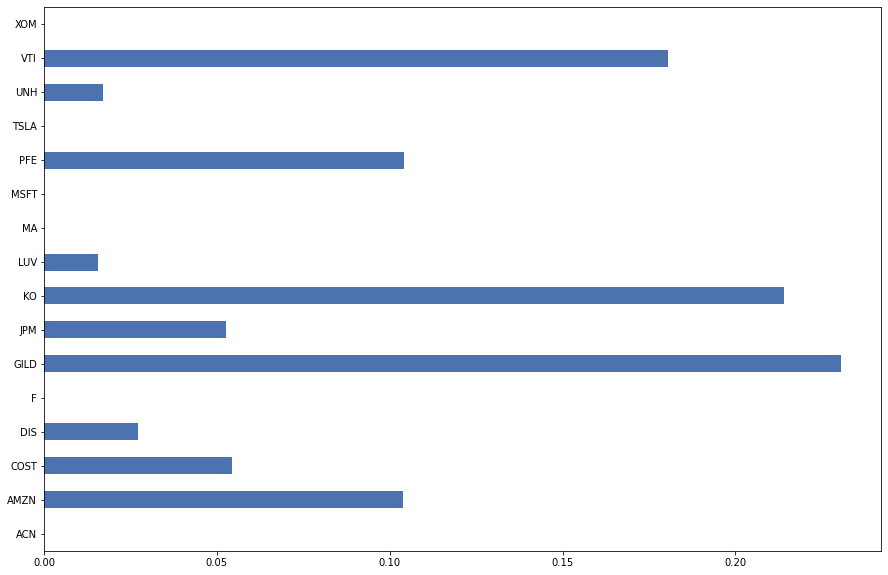

In [74]:
pd.Series(weights_ec).plot.barh(figsize=(15,10));

<AxesSubplot:>

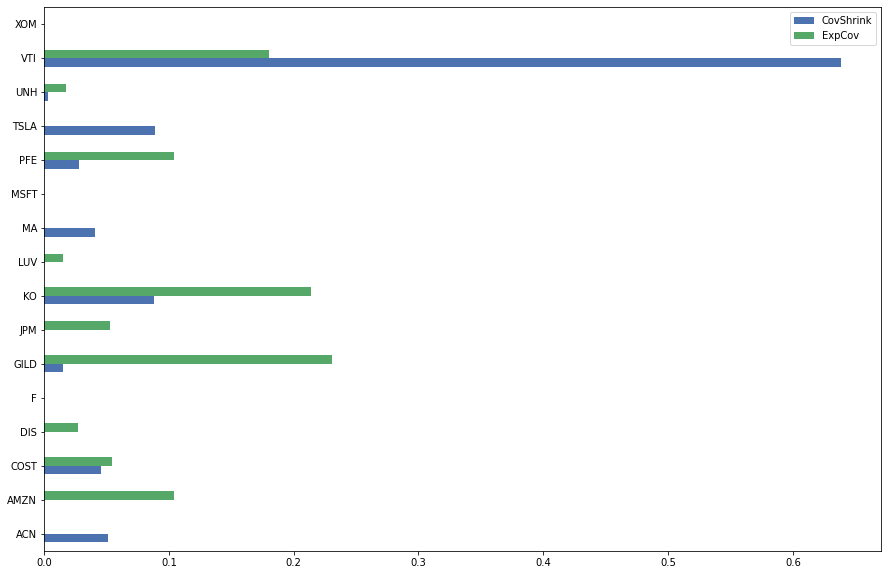

In [75]:
cs_weights_df = pd.Series(weights_cs).to_frame(name='CovShrink')
ec_weights_df = pd.Series(weights_ec).to_frame(name='ExpCov')
# weights_ec['risk_model']='exp_cov'
df1 = pd.concat([cs_weights_df,ec_weights_df],axis=1)
df1.plot.barh(figsize=(15,10))

We can get a quick indication of the portfolio performance as follows. Note that this is an in sample estimate and may have very little resemblance to how the portfolio actually performs!

In [76]:
ef_cs.portfolio_performance(verbose=True);

Annual volatility: 10.8%


In [77]:
ef_ec.portfolio_performance(verbose=True);

Annual volatility: 10.9%


Let's say we were happy with this portfolio and wanted to actually go out and buy the shares.  To do this, we would need to construct a **discrete allocation** (unless your broker supports fractional shares!)

If we had \$20,0000 to invest and would like our portfolio to be 130/30 long/short, we can construct the actual allocation as follows:

In [78]:
from pypfopt import DiscreteAllocation

latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights_cs, latest_prices, total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Long-step dual simplex will be used
Discrete allocation performed with $13.22 leftover


{'ACN': 2,
 'COST': 2,
 'GILD': 2,
 'KO': 29,
 'MA': 2,
 'PFE': 9,
 'TSLA': 2,
 'VTI': 53}

In [79]:
yf.Tickers.download()

TypeError: download() missing 1 required positional argument: 'self'